In [29]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import pandas as pd
import random

In [30]:
# Cell 2: AudioTransform class for data augmentation
class AudioTransform:
    def __init__(self, time_mask_prob=0.5, freq_mask_prob=0.5, time_stretch_prob=0.5):
        self.time_mask_prob = time_mask_prob
        self.freq_mask_prob = freq_mask_prob
        self.time_stretch_prob = time_stretch_prob
        
    def time_mask(self, mel_spec, max_mask_length=0.1):
        """Áp dụng time masking cho mel spectrogram"""
        if random.random() < self.time_mask_prob:
            # Lấy shape của mel spectrogram
            if len(mel_spec.shape) == 3:  # Nếu có channel dimension
                _, n_mels, n_time = mel_spec.shape
                mel_spec = mel_spec[0]  # Lấy channel đầu tiên
            else:
                n_mels, n_time = mel_spec.shape
                
            mask_length = int(n_time * max_mask_length)
            mask_start = random.randint(0, n_time - mask_length)
            mel_spec[:, mask_start:mask_start + mask_length] = 0
            
            if len(mel_spec.shape) == 2:  # Nếu ban đầu có channel dimension
                mel_spec = np.expand_dims(mel_spec, axis=0)
        return mel_spec
    
    def freq_mask(self, mel_spec, max_mask_length=0.1):
        """Áp dụng frequency masking cho mel spectrogram"""
        if random.random() < self.freq_mask_prob:
            # Lấy shape của mel spectrogram
            if len(mel_spec.shape) == 3:  # Nếu có channel dimension
                _, n_mels, n_time = mel_spec.shape
                mel_spec = mel_spec[0]  # Lấy channel đầu tiên
            else:
                n_mels, n_time = mel_spec.shape
                
            mask_length = int(n_mels * max_mask_length)
            mask_start = random.randint(0, n_mels - mask_length)
            mel_spec[mask_start:mask_start + mask_length, :] = 0
            
            if len(mel_spec.shape) == 2:  # Nếu ban đầu có channel dimension
                mel_spec = np.expand_dims(mel_spec, axis=0)
        return mel_spec
    
    def time_stretch(self, mel_spec, stretch_range=(0.8, 1.2)):
        """Áp dụng time stretching cho mel spectrogram"""
        if random.random() < self.time_stretch_prob:
            # Lấy shape của mel spectrogram
            if len(mel_spec.shape) == 3:  # Nếu có channel dimension
                _, n_mels, n_time = mel_spec.shape
                mel_spec = mel_spec[0]  # Lấy channel đầu tiên
            else:
                n_mels, n_time = mel_spec.shape
                
            stretch_factor = random.uniform(*stretch_range)
            new_time = int(n_time * stretch_factor)
            stretched = np.zeros((n_mels, new_time))
            
            for i in range(n_mels):
                stretched[i] = np.interp(
                    np.linspace(0, n_time, new_time),
                    np.arange(n_time),
                    mel_spec[i]
                )
            
            # Resize về kích thước ban đầu
            if stretch_factor > 1:
                # Nếu stretch > 1, cắt bớt
                mel_spec = stretched[:, :n_time]
            else:
                # Nếu stretch < 1, padding
                mel_spec = np.pad(stretched, ((0, 0), (0, n_time - new_time)))
                
            if len(mel_spec.shape) == 2:  # Nếu ban đầu có channel dimension
                mel_spec = np.expand_dims(mel_spec, axis=0)
                
        return mel_spec
    
    def __call__(self, mel_spec):
        """Áp dụng tất cả các augmentation"""
        mel_spec = self.time_mask(mel_spec)
        mel_spec = self.freq_mask(mel_spec)
        mel_spec = self.time_stretch(mel_spec)
        return mel_spec

In [31]:
# Cell 3: LoadData class for dataset handling
class LoadData(Dataset):
    def __init__(self, data_dir, transform=None, custom_data=None):
        self.data_dir = data_dir
        self.transform = transform
        # Lọc bỏ metadata.csv khỏi danh sách classes
        self.classes = [d for d in sorted(os.listdir(data_dir)) 
                       if os.path.isdir(os.path.join(data_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        if custom_data is not None:
            # Chuyển đổi label từ string sang index
            self.samples = [(path, self.class_to_idx[label]) for path, label in custom_data]
        else:
            self.samples = []
            for class_name in self.classes:
                class_dir = os.path.join(data_dir, class_name)
                for file_name in os.listdir(class_dir):
                    if file_name.endswith('.npy'):  # Đặc trưng mel spectrogram
                        self.samples.append((os.path.join(class_dir, file_name), self.class_to_idx[class_name]))
    
    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        features = np.load(file_path)
        
        if len(features.shape) == 2:
            features = np.expand_dims(features, axis=0)
            
        if self.transform:
            features = self.transform(features)
            
        return torch.FloatTensor(features), torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.samples)

# Cell 4: Create datasets and dataloaders
# Đọc metadata để chia train/test/val
metadata = pd.read_csv('../data/features/mel/metadata.csv')

# Tạo dataset với đường dẫn đầy đủ
base_dir = '../data/features/mel'

# Tạo transform cho augmentation
train_transform = AudioTransform(
    time_mask_prob=0.5,
    freq_mask_prob=0.5,
    time_stretch_prob=0.5
)

# Chia dữ liệu theo từng class
train_data = []
val_data = []
test_data = []

for class_name in sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]):
    class_dir = os.path.join(base_dir, class_name)
    files = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
    
    # Shuffle files
    random.seed(42)
    random.shuffle(files)
    
    # Chia theo tỷ lệ 75-15-10
    n_files = len(files)
    n_train = int(0.75 * n_files)
    n_val = int(0.15 * n_files)
    
    # Chia files cho từng tập
    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]
    
    # Thêm đường dẫn đầy đủ và nhãn
    train_data.extend([(os.path.join(class_dir, f), class_name) for f in train_files])
    val_data.extend([(os.path.join(class_dir, f), class_name) for f in val_files])
    test_data.extend([(os.path.join(class_dir, f), class_name) for f in test_files])

# Tạo datasets
train_ds = LoadData(base_dir, transform=train_transform, custom_data=train_data)
val_ds = LoadData(base_dir, transform=None, custom_data=val_data)
test_ds = LoadData(base_dir, transform=None, custom_data=test_data)

# Tạo DataLoader
batch_size = 32
dataloaders = {
    'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8),
    'val': DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8), 
    'test': DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8),
}

# In thông tin về dataset
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples: {len(test_ds)}")
print(f"Number of classes: {len(train_ds.classes)}")
print(f"Classes: {train_ds.classes}")

# In thông tin về phân phối class trong mỗi tập
def get_class_distribution(dataset):
    distribution = {i: 0 for i in range(len(dataset.classes))}
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        distribution[label.item()] += 1
    return {dataset.classes[i]: count for i, count in distribution.items()}

print("\nClass distribution in training set:")
print(get_class_distribution(train_ds))
print("\nClass distribution in validation set:")
print(get_class_distribution(val_ds))
print("\nClass distribution in test set:")
print(get_class_distribution(test_ds))

Number of training samples: 1385
Number of validation samples: 274
Number of test samples: 194
Number of classes: 13
Classes: ['bat_den', 'bat_dieu_hoa', 'bat_quat', 'bat_tv', 'do_am', 'dong_rem', 'mo_rem', 'nhiet_do', 'tat_den', 'tat_dieu_hoa', 'tat_quat', 'tat_tv', 'unknown']

Class distribution in training set:
{'bat_den': 111, 'bat_dieu_hoa': 103, 'bat_quat': 105, 'bat_tv': 100, 'do_am': 111, 'dong_rem': 104, 'mo_rem': 105, 'nhiet_do': 110, 'tat_den': 110, 'tat_dieu_hoa': 104, 'tat_quat': 105, 'tat_tv': 105, 'unknown': 112}

Class distribution in validation set:
{'bat_den': 22, 'bat_dieu_hoa': 20, 'bat_quat': 21, 'bat_tv': 20, 'do_am': 22, 'dong_rem': 20, 'mo_rem': 21, 'nhiet_do': 22, 'tat_den': 22, 'tat_dieu_hoa': 20, 'tat_quat': 21, 'tat_tv': 21, 'unknown': 22}

Class distribution in test set:
{'bat_den': 16, 'bat_dieu_hoa': 15, 'bat_quat': 15, 'bat_tv': 14, 'do_am': 15, 'dong_rem': 15, 'mo_rem': 14, 'nhiet_do': 15, 'tat_den': 15, 'tat_dieu_hoa': 15, 'tat_quat': 14, 'tat_tv': 15,

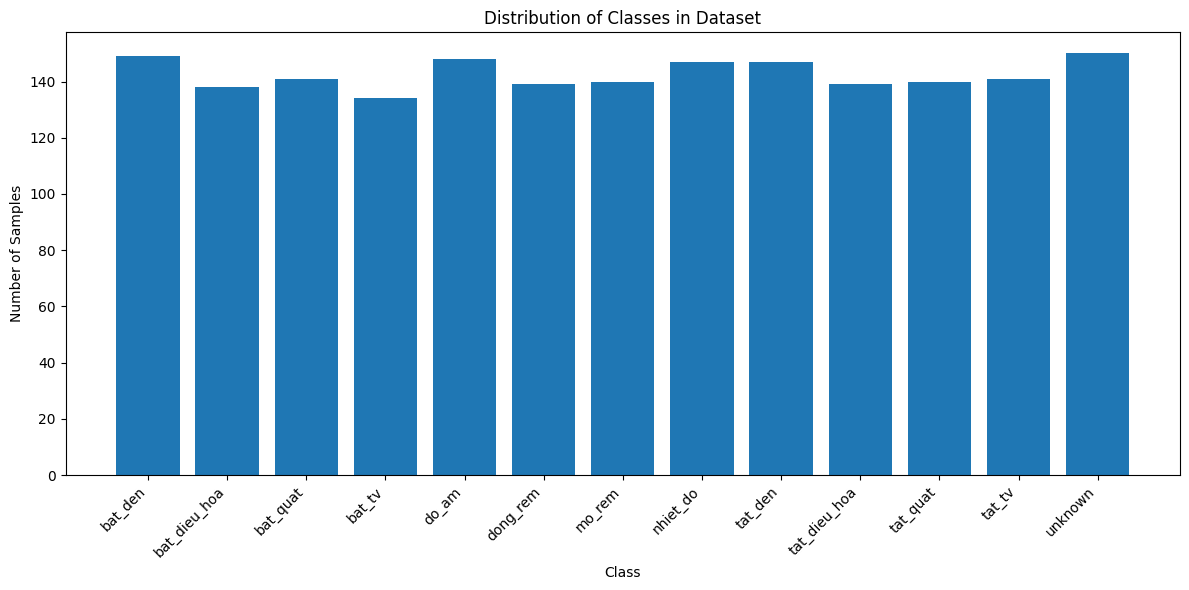


Class Distribution:
bat_den: 149 samples
bat_dieu_hoa: 138 samples
bat_quat: 141 samples
bat_tv: 134 samples
do_am: 148 samples
dong_rem: 139 samples
mo_rem: 140 samples
nhiet_do: 147 samples
tat_den: 147 samples
tat_dieu_hoa: 139 samples
tat_quat: 140 samples
tat_tv: 141 samples
unknown: 150 samples


In [32]:
# [OPTIONAL]
# Tính số lượng samples cho mỗi class

# Tạo full dataset chứa toàn bộ dữ liệu
full_ds = LoadData(base_dir, transform=None)

class_counts = {}
for class_name in full_ds.classes:
    class_dir = os.path.join(base_dir, class_name)
    class_counts[class_name] = len([f for f in os.listdir(class_dir) if f.endswith('.npy')])

# Vẽ bar plot
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# In thông tin chi tiết
print("\nClass Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} samples")



In [33]:
# # [OPTIONAL]
# def plot_sample_spectrograms(dataset, num_samples=3):
#     plt.figure(figsize=(15, 4*len(dataset.classes)))
    
#     for class_idx, class_name in enumerate(dataset.classes):
#         # Lấy indices của class hiện tại
#         class_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
        
#         # Lấy ngẫu nhiên num_samples mẫu
#         sample_indices = random.sample(class_indices, min(num_samples, len(class_indices)))
        
#         for i, idx in enumerate(sample_indices):
#             plt.subplot(len(dataset.classes), num_samples, class_idx*num_samples + i + 1)
#             mel_spec, _ = dataset[idx]
#             plt.imshow(mel_spec[0], aspect='auto', origin='lower')
#             plt.title(f'{class_name} - Sample {i+1}')
#             plt.xlabel('Time')
#             plt.ylabel('Frequency')
#             plt.colorbar()
    
#     plt.tight_layout()
#     plt.show()

# # Gọi hàm để hiển thị
# plot_sample_spectrograms(full_ds)

In [34]:
# Cell 5: ConvMixer model definition
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=12):  # Sửa thành 12 classes
    return nn.Sequential(
        nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size),  # Input channel = 1 cho mel spectrogram
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=kernel_size, groups=dim, padding="same"),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            )),
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [35]:
# Cell 6: Initialize model and training parameters
# Khởi tạo mô hình
model = ConvMixer(dim=256, depth=8, n_classes=13)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Kiểm tra và chuyển model lên GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Các tham số training
num_epochs = 25
patience = 5  # Số epoch chờ đợi trước khi early stopping
min_delta = 0.02  # Ngưỡng cải thiện tối thiểu

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.2,  # Giảm learning rate mạnh hơn
    patience=3,
    min_lr=1e-6  # Learning rate tối thiểu
)

# In thông tin về model và device
print(f"Model architecture:\n{model}")
print(f"Using device: {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Model architecture:
Sequential(
  (0): Conv2d(1, 256, kernel_size=(7, 7), stride=(7, 7))
  (1): GELU(approximate='none')
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Sequential(
    (0): Residual(
      (fn): Sequential(
        (0): Conv2d(256, 256, kernel_size=(9, 9), stride=(1, 1), padding=same, groups=256)
        (1): GELU(approximate='none')
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (2): GELU(approximate='none')
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Residual(
      (fn): Sequential(
        (0): Conv2d(256, 256, kernel_size=(9, 9), stride=(1, 1), padding=same, groups=256)
        (1): GELU(approximate='none')
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    

In [36]:
# Cell 7: Training loop
# Khởi tạo các list để lưu metrics
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
best_index = 0
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Tính và lưu training loss
    epoch_train_loss = running_loss / len(dataloaders['train'])
    train_losses.append(epoch_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Tính và lưu validation metrics
    epoch_val_loss = val_loss / len(dataloaders['val'])
    val_acc = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_acc)
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    # Cập nhật learning rate
    scheduler.step(val_acc)
    print(f'Current learning rate: {optimizer.param_groups[0]["lr"]:.6f}')

    # Early stopping check
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        patience_counter = 0
        # Lưu model tốt nhất
        best_index = epoch
        torch.save(model.state_dict(), '../data/models/audio_classifier_best.pth')
        print(f'New best model saved! Validation Accuracy: {val_acc:.2f}%')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs')
        
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

# Lưu model cuối cùng
torch.save(model.state_dict(), '../data/models/audio_classifier_final.pth')
print("Training completed!")

Epoch 1/25, Training Loss: 2.0275
Validation Loss: 2.9240, Validation Accuracy: 19.71%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 19.71%
Epoch 2/25, Training Loss: 1.4821
Validation Loss: 1.0365, Validation Accuracy: 64.23%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 64.23%
Epoch 3/25, Training Loss: 1.0926
Validation Loss: 0.7774, Validation Accuracy: 70.07%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 70.07%
Epoch 4/25, Training Loss: 0.7842
Validation Loss: 0.6836, Validation Accuracy: 74.82%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 74.82%
Epoch 5/25, Training Loss: 0.6061
Validation Loss: 0.4273, Validation Accuracy: 83.58%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 83.58%
Epoch 6/25, Training Loss: 0.4361
Validation Loss: 0.2821, Validation Accuracy: 89.78%
Current learning rate: 0.001000
New best model saved! Validation Acc

In [37]:
print(f"\nBest validation accuracy: {best_val_acc:.2f}% of epoch {best_index + 1}")


Best validation accuracy: 98.91% of epoch 23


In [38]:
# # [OPTIONAL]
# # Lưu learning rate history
# lr_history = []
# for param_group in optimizer.param_groups:
#     lr_history.append(param_group['lr'])

# plt.figure(figsize=(10, 4))
# plt.plot(lr_history, marker='o')
# plt.title('Learning Rate Schedule')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.yscale('log')  # Log scale để dễ nhìn sự thay đổi
# plt.grid(True)
# plt.show()

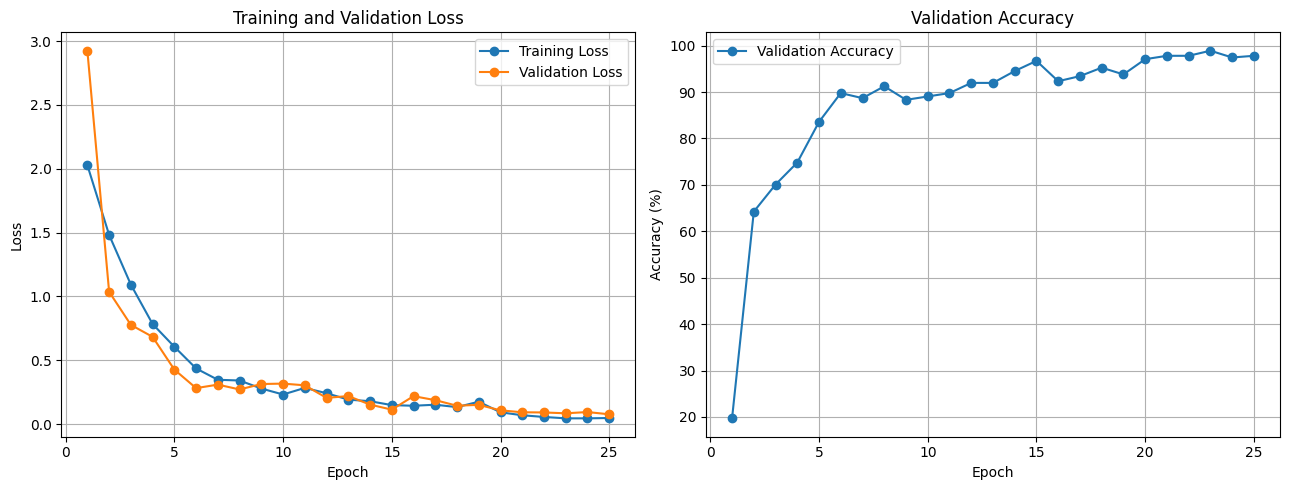

In [39]:
# Cell 8: Plot training and validation loss
plt.figure(figsize=(13, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test Loss: 0.1123
Test Accuracy: 97.42%


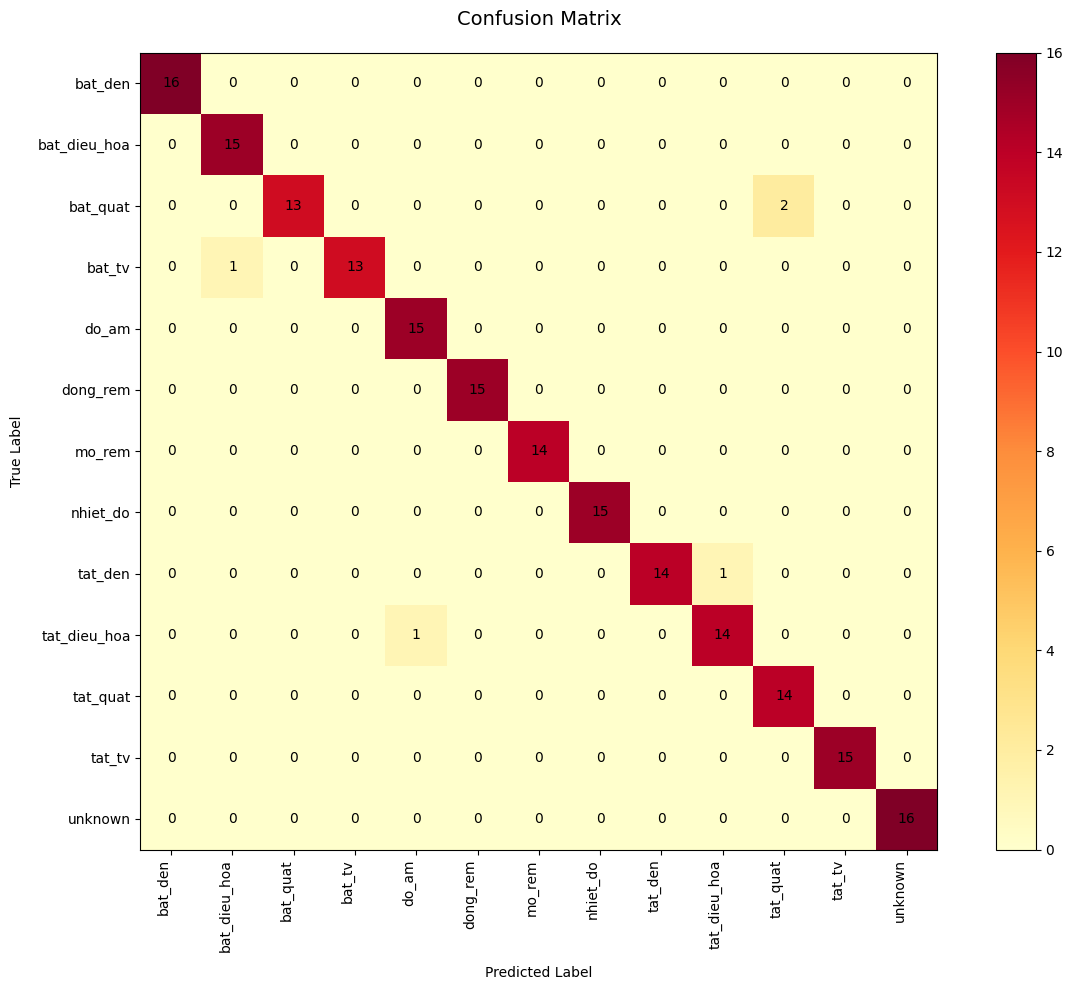


Classification Report:
              precision    recall  f1-score   support

     bat_den       1.00      1.00      1.00        16
bat_dieu_hoa       0.94      1.00      0.97        15
    bat_quat       1.00      0.87      0.93        15
      bat_tv       1.00      0.93      0.96        14
       do_am       0.94      1.00      0.97        15
    dong_rem       1.00      1.00      1.00        15
      mo_rem       1.00      1.00      1.00        14
    nhiet_do       1.00      1.00      1.00        15
     tat_den       1.00      0.93      0.97        15
tat_dieu_hoa       0.93      0.93      0.93        15
    tat_quat       0.88      1.00      0.93        14
      tat_tv       1.00      1.00      1.00        15
     unknown       1.00      1.00      1.00        16

    accuracy                           0.97       194
   macro avg       0.98      0.97      0.97       194
weighted avg       0.98      0.97      0.97       194



In [40]:
# Cell 9: Evaluate on test set and plot confusion matrix
def evaluate_model(model, dataloader, criterion, device):
    """Đánh giá model trên tập test"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    test_acc = 100 * correct / total
    avg_loss = test_loss / len(dataloader)
    
    return avg_loss, test_acc, all_labels, all_predictions

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Vẽ confusion matrix"""
    plt.figure(figsize=(13, 10))
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=class_names
    )
    
    cm_display.plot(cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Load model tốt nhất
model.load_state_dict(torch.load('../data/models/audio_classifier_best.pth'))

# Đánh giá model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(
    model, dataloaders['test'], criterion, device
)

# In kết quả
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

# Vẽ confusion matrix
plt.figure(figsize=(13, 10))
confusion_matrix = metrics.confusion_matrix(all_labels, all_predictions)

# Vẽ heatmap
plt.imshow(confusion_matrix, cmap='YlOrRd')
plt.colorbar()

# Thêm giá trị vào từng ô
for i in range(len(full_ds.classes)):
    for j in range(len(full_ds.classes)):
        plt.text(j, i, f'{confusion_matrix[i, j]}',
                ha='center', va='center')

plt.title('Confusion Matrix', pad=20, fontsize=14)
plt.xlabel('Predicted Label', labelpad=10)
plt.ylabel('True Label', labelpad=10)

# Thêm labels
plt.xticks(range(len(full_ds.classes)), full_ds.classes, rotation=90, ha='right')
plt.yticks(range(len(full_ds.classes)), full_ds.classes)

plt.tight_layout()
plt.show()

# In classification report
print("\nClassification Report:")
print(metrics.classification_report(all_labels, all_predictions, target_names=full_ds.classes))

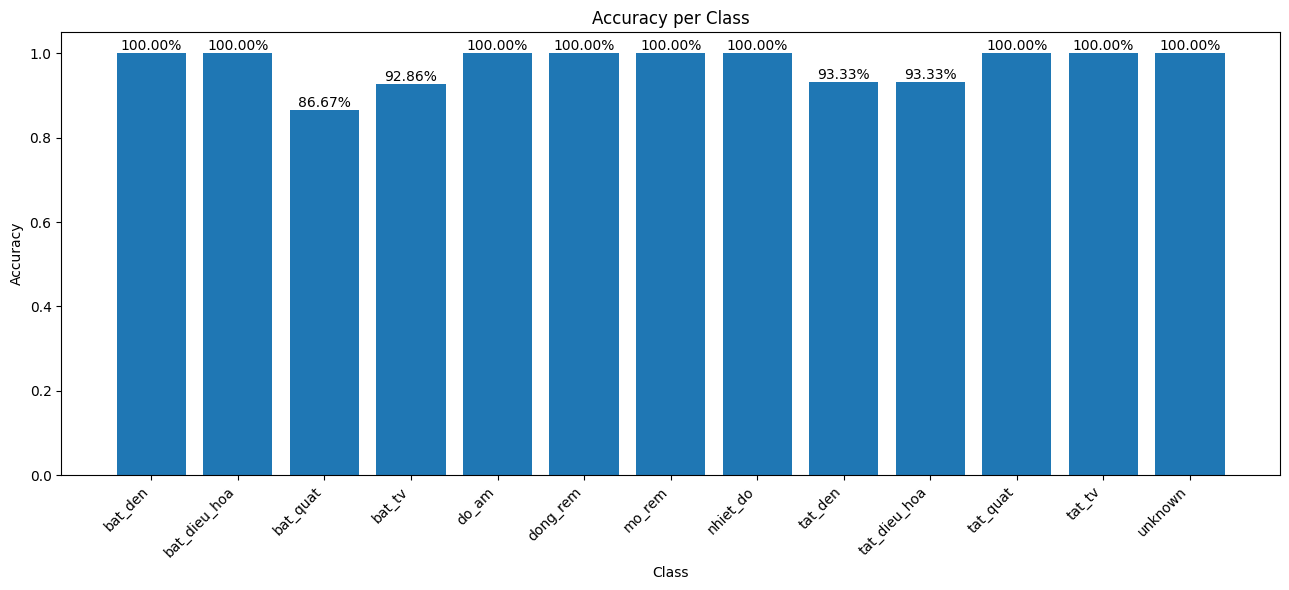

In [41]:
# [OPTIONAL]
def plot_class_accuracy(y_true, y_pred, class_names):
    # Tính accuracy cho từng class
    class_accuracies = []
    for i in range(len(class_names)):
        mask = (y_true == i)
        if sum(mask) > 0:
            accuracy = np.mean(y_pred[mask] == y_true[mask])
            class_accuracies.append(accuracy)
        else:
            class_accuracies.append(0)
    
    # Vẽ bar plot
    plt.figure(figsize=(13, 6))
    bars = plt.bar(class_names, class_accuracies)
    plt.title('Accuracy per Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    
    # Thêm giá trị accuracy lên mỗi bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị
plot_class_accuracy(np.array(all_labels), np.array(all_predictions), full_ds.classes)

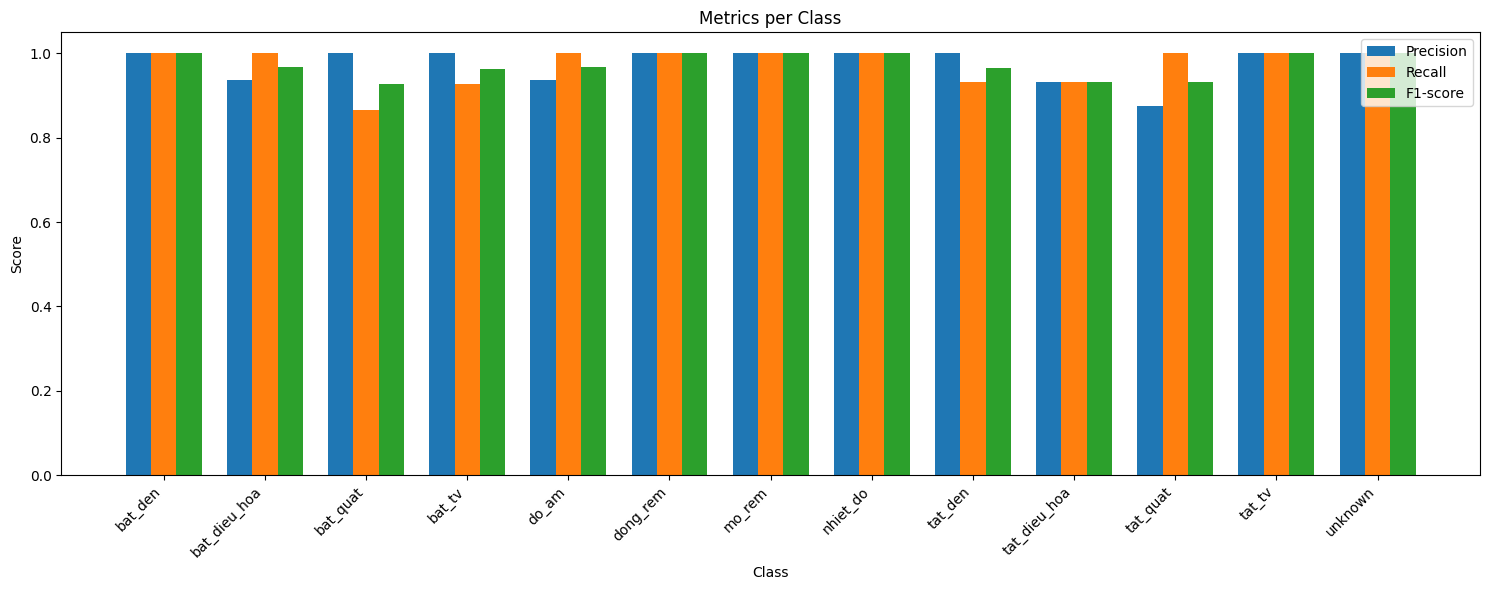

In [42]:
# [OPTIONAL]
def plot_metrics(y_true, y_pred, class_names):
    # Tính precision, recall, f1-score cho từng class
    precision = metrics.precision_score(y_true, y_pred, average=None)
    recall = metrics.recall_score(y_true, y_pred, average=None)
    f1 = metrics.f1_score(y_true, y_pred, average=None)
    
    # Vẽ grouped bar chart
    x = np.arange(len(class_names))
    width = 0.25
    
    plt.figure(figsize=(15, 6))
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1, width, label='F1-score')
    
    plt.title('Metrics per Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị
plot_metrics(np.array(all_labels), np.array(all_predictions), full_ds.classes)